In [27]:
!pip install pandas numpy python-Levenshtein tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 77.7 MB/s eta 0:00:00


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
path = '/content/drive/MyDrive/Cummings/'

In [30]:
import re
import pandas as pd
from Levenshtein import distance
from tqdm import tqdm
import os

def parse_chat_file(filepath):
    records = []
    metadata = {"child_id": None, "date": None, "session": None}
    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if line.startswith("@ID:"):
                parts = line.split("|")
                if len(parts) > 3:
                    metadata["child_id"] = parts[2]
            elif line.startswith("@Date:"):
                metadata["date"] = line.replace("@Date:", "").strip()
            elif line.startswith("@Situation:"):
                metadata["session"] = line.replace("@Situation:", "").strip()
            elif line.startswith("*CHI:"):
                current_word = re.sub(r"[*CHI:\t.]", "", line).strip()
            elif line.startswith("%xmod:"):
                target_phon = line.replace("%xmod:\t", "").strip()
            elif line.startswith("%xpho:"):
                produced_phon = line.replace("%xpho:\t", "").strip()
                if all([current_word, target_phon, produced_phon]):
                    records.append({
                        **metadata,
                        "word": current_word,
                        "target_phon": target_phon,
                        "produced_phon": produced_phon
                    })
                    current_word = None

    return pd.DataFrame(records)

def compute_pcc(target, produced):
    consonants = set("pbtdkgfvθðszʃʒhmnŋlrjwɹʔɾ")
    t = list(target.replace(" ", ""))
    p = list(produced.replace(" ", ""))
    min_len = min(len(t), len(p))
    matches = sum(1 for i in range(min_len) if t[i] == p[i] and t[i] in consonants)
    total_cons = sum(1 for c in t if c in consonants)
    return (matches / total_cons * 100) if total_cons > 0 else None


In [31]:
import nltk
nltk.download('words')
from nltk.corpus import words

english_vocab = set(w.lower() for w in words.words())

#quick scan of unknown words:
# The following line is commented out as it was for diagnostic purposes:
# unknowns = [w for w in df_all["word"].unique() if w.lower() not in english_vocab]
# print(unknowns[:50])

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [34]:
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm import tqdm

#function to parse a single XML file
def parse_phon_xml(filepath):
    ns = {"p": "http://phon.ling.mun.ca/ns/phonbank"}
    try:
        tree = ET.parse(filepath)
    except Exception as e:
        print(f"Skipping {filepath}: {e}")
        return pd.DataFrame()

    root = tree.getroot()
    file_records = []

    for u in root.findall(".//p:u", ns):
        ortho_elems = u.findall(".//p:orthography//p:w", ns)
        model_elems = u.findall(".//p:ipaTier[@form='model']//p:w", ns)
        actual_elems = u.findall(".//p:ipaTier[@form='actual']//p:w", ns)

        if not ortho_elems or not model_elems or not actual_elems:
            continue

        ortho_word = " ".join(e.text for e in ortho_elems if e.text)
        model_ipa = " ".join(e.text for e in model_elems if e.text)
        actual_ipa = " ".join(e.text for e in actual_elems if e.text)

        #classifying lexicality
        lexicality = "realword" if ortho_word.lower() in english_vocab else "nonword"

        file_records.append({
            "file": os.path.basename(filepath),
            "orthography": ortho_word,
            "ipa_model": model_ipa,
            "ipa_actual": actual_ipa,
            "lexicality": lexicality
        })

    return pd.DataFrame(file_records)

#loop through every XML file in the Cummings folder
all_dfs = []
for filename in tqdm(os.listdir(path)):
    if filename.endswith(".xml"):
        file_path = os.path.join(path, filename)
        df = parse_phon_xml(file_path)
        all_dfs.append(df)

#combining all parsed XMLs
df_all_xml = pd.concat(all_dfs, ignore_index=True)

#saving structured dataset
df_all_xml.to_csv("Cummings_all_stimuli.csv", index=False)

df_all_xml.head(10)

100%|██████████| 253/253 [00:03<00:00, 73.73it/s]


,file,orthography,ipa_model,ipa_actual,lexicality
0,030210.xml,glasses,glæsɪz,glæsɪs,realword
1,030210.xml,ghost,goʊst,goʊs,realword
2,030210.xml,six,sɪks,sɪks,realword
3,030210.xml,vacuum,vækjum,fækju,realword
4,030210.xml,elephant,ɛləfɪnt,ɛlflɪntʰ,realword
5,030210.xml,zebra,zibrə,ziba,realword
6,030210.xml,zoo,zu,zu,realword
7,030210.xml,brush,brʌʃ,bʌs,realword
8,030210.xml,blue,blu,bəlu,realword
9,030210.xml,plate,pleɪt,bəleɪtʰ,realword


In [38]:
import os
from tqdm import tqdm

path = '/content/drive/MyDrive/Cummings/'

all_data_frames = []

for file in tqdm(os.listdir(path)):
    if file.endswith(".cha"):
        filepath = os.path.join(path, file)

        #parsing the CHA file with the existing function
        df_temp = parse_chat_file(filepath)

        #adding original_filename to every row
        df_temp["original_filename"] = file

        #overwriting child_id with the first two digits of the filename
        #the child_id from @ID: line is often 'CHI' or similar, not a unique identifier
        df_temp["child_id"] = file[:2]

        #appending the temporary DataFrame to the list
        all_data_frames.append(df_temp)

#combining all parsed DataFrames into a single DataFrame
df_all = pd.concat(all_data_frames, ignore_index=True)

df_all.head()

100%|██████████| 253/253 [00:01<00:00, 134.88it/s]


,child_id,date,session,word,target_phon,produced_phon,original_filename
0,04,01-JAN-1984,None,zebra 2649_5649,zibrə,bibɑ,040300.cha
1,04,01-JAN-1984,None,zoo 6549_9549,zu,diu,040300.cha
2,04,01-JAN-1984,None,brush 11250_14250,brʌʃ,bɑsː,040300.cha
3,04,01-JAN-1984,None,blue 15650_18650,blu,bwu,040300.cha
4,04,01-JAN-1984,None,shark 19901_22901,ʃɑrk,gʌk,040300.cha


In [42]:
import numpy as np

#extracting MMDDYY from original_filename
df_all["file_date_str"] = df_all["original_filename"].str.extract(r"^(\d{6})")

#split into month, day, year
df_all["month"] = df_all["file_date_str"].str[0:2]
df_all["day"] = df_all["file_date_str"].str[2:4]
df_all["year_short"] = df_all["file_date_str"].str[4:6].astype(int)

#infering century: years <= 30 are 20XX, years > 30 are 19XX
df_all["year"] = df_all["year_short"].apply(lambda y: 2000 + y if y <= 30 else 1900 + y)

#combining into a proper datetime object and update the 'date' column
df_all["date"] = pd.to_datetime(
    df_all["year"].astype(str) + "-" +
    df_all["month"] + "-" +
    df_all["day"],
    errors='coerce'
)

#storing original session label extracted from @Situation: line (if any)
df_all["original_session_label"] = df_all["session"]

#initializing a new 'session' column for final labels
df_all["session"] = df_all["original_session_label"].fillna("unknown") # Use original if present, else temporary 'unknown'

#for records where original_session_label was None/NaN, apply 'pre', 'post', 'probe' logic
null_session_mask = df_all["original_session_label"].isna()

#calculating min and max dates for ALL records, ensuring the Series aligns with df_all
min_dates_all_children = df_all.groupby("child_id")["date"].transform("min")
max_dates_all_children = df_all.groupby("child_id")["date"].transform("max")

#assigning 'pre', 'post', 'probe' to the relevant rows in the 'session' column
df_all.loc[null_session_mask & (df_all["date"] == min_dates_all_children), "session"] = "pre"
df_all.loc[null_session_mask & (df_all["date"] == max_dates_all_children), "session"] = "post"
df_all.loc[null_session_mask &
           (df_all["date"] != min_dates_all_children) &
           (df_all["date"] != max_dates_all_children), "session"] = "probe"

#drop intermediate columns used for date parsing if no longer needed
df_all = df_all.drop(columns=["file_date_str", "month", "day", "year_short", "year", "original_session_label"])

df_all.head()

,child_id,date,session,word,target_phon,produced_phon,original_filename
0,04,2000-04-03,pre,zebra 2649_5649,zibrə,bibɑ,040300.cha
1,04,2000-04-03,pre,zoo 6549_9549,zu,diu,040300.cha
2,04,2000-04-03,pre,brush 11250_14250,brʌʃ,bɑsː,040300.cha
3,04,2000-04-03,pre,blue 15650_18650,blu,bwu,040300.cha
4,04,2000-04-03,pre,shark 19901_22901,ʃɑrk,gʌk,040300.cha


In [43]:
df_all["lev_distance"] = df_all.apply(lambda x: distance(x.target_phon, x.produced_phon), axis=1)
df_all["pcc"] = df_all.apply(lambda x: compute_pcc(x.target_phon, x.produced_phon), axis=1)

# Clean the 'word' column by removing TalkBank timestamp markers and converting to lowercase
df_all["word_clean"] = df_all["word"].apply(
    lambda x: re.sub(r"\s*\x15\d+_\d+\x15", "", str(x)).strip().lower()
)

df_all.head()

,child_id,date,session,word,target_phon,produced_phon,original_filename,lev_distance,pcc,word_clean
0,04,2000-04-03,pre,zebra 2649_5649,zibrə,bibɑ,040300.cha,3,33.333333,zebra
1,04,2000-04-03,pre,zoo 6549_9549,zu,diu,040300.cha,2,0.000000,zoo
2,04,2000-04-03,pre,brush 11250_14250,brʌʃ,bɑsː,040300.cha,3,33.333333,brush
3,04,2000-04-03,pre,blue 15650_18650,blu,bwu,040300.cha,1,50.000000,blue
4,04,2000-04-03,pre,shark 19901_22901,ʃɑrk,gʌk,040300.cha,3,0.000000,shark


In [45]:
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.corpus import words

nltk.download('words')
english_vocab = set(w.lower() for w in words.words())

#function to parse a single XML file
def parse_phon_xml(filepath):
    ns = {"p": "http://phon.ling.mun.ca/ns/phonbank"}
    try:
        tree = ET.parse(filepath)
    except Exception as e:
        print(f"Skipping {filepath}: {e}")
        return pd.DataFrame()

    root = tree.getroot()
    file_records = []

    for u in root.findall(".//p:u", ns):
        ortho_elems = u.findall(".//p:orthography//p:w", ns)
        model_elems = u.findall(".//p:ipaTier[@form='model']//p:w", ns)
        actual_elems = u.findall(".//p:ipaTier[@form='actual']//p:w", ns)

        if not ortho_elems or not model_elems or not actual_elems:
            continue

        ortho_word = " ".join(e.text for e in ortho_elems if e.text)
        model_ipa = " ".join(e.text for e in model_elems if e.text)
        actual_ipa = " ".join(e.text for e in actual_elems if e.text)

        #classify lexicality
        lexicality = "realword" if ortho_word.lower() in english_vocab else "nonword"

        file_records.append({
            "file": os.path.basename(filepath),
            "orthography": ortho_word,
            "ipa_model": model_ipa,
            "ipa_actual": actual_ipa,
            "lexicality": lexicality
        })

    return pd.DataFrame(file_records)



all_dfs_xml = []
for filename in tqdm(os.listdir(path)):
    if filename.endswith(".xml"):
        file_path = os.path.join(path, filename)
        df = parse_phon_xml(file_path)
        all_dfs_xml.append(df)

#combining all parsed XMLs
df_all_xml = pd.concat(all_dfs_xml, ignore_index=True)

#creating orthography_clean in df_all_xml
df_all_xml["orthography_clean"] = df_all_xml["orthography"].str.lower().str.strip()

#performing a left merge of df_all with df_all_xml
df_merged = pd.merge(
    df_all,
    df_all_xml[["orthography_clean", "lexicality"]],
    left_on="word_clean",
    right_on="orthography_clean",
    how="left"
)

#displaying the first few rows of df_merged to verify the new lexicality column
df_merged.head()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
100%|██████████| 253/253 [00:03<00:00, 69.61it/s]


,child_id,date,session,word,target_phon,produced_phon,original_filename,lev_distance,pcc,word_clean,orthography_clean,lexicality
0,04,2000-04-03,pre,zebra 2649_5649,zibrə,bibɑ,040300.cha,3,33.333333,zebra,zebra,realword
1,04,2000-04-03,pre,zebra 2649_5649,zibrə,bibɑ,040300.cha,3,33.333333,zebra,zebra,realword
2,04,2000-04-03,pre,zebra 2649_5649,zibrə,bibɑ,040300.cha,3,33.333333,zebra,zebra,realword
3,04,2000-04-03,pre,zebra 2649_5649,zibrə,bibɑ,040300.cha,3,33.333333,zebra,zebra,realword
4,04,2000-04-03,pre,zebra 2649_5649,zibrə,bibɑ,040300.cha,3,33.333333,zebra,zebra,realword


In [46]:
print("Lexicality information merged successfully.")

Lexicality information merged successfully.


In [47]:
df_merged["accuracy"] = (df_merged["pcc"] >= 80).astype(int)

df_item = (
    df_merged.groupby(["child_id", "session", "word_clean", "lexicality"], as_index=False)
    .agg(
        mean_pcc=("pcc", "mean"),
        accuracy=("accuracy", "mean")
    )
)

print(df_item.shape)
df_item.head()

(3149, 6)


,child_id,session,word_clean,lexicality,mean_pcc,accuracy
0,03,post,badge,realword,100.0,1.0
1,03,post,badgei,nonword,100.0,1.0
2,03,post,bridge,realword,50.0,0.0
3,03,post,bridgei,nonword,50.0,0.0
4,03,post,cage,realword,100.0,1.0


In [48]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "accuracy ~ lexicality * session",
    data=df_item,
    groups=df_item["child_id"]
)
result = model.fit()
print(result.summary())

                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         accuracy  
No. Observations:           3149            Method:                     REML      
No. Groups:                 5               Scale:                      0.1576    
Min. group size:            488             Log-Likelihood:             -1583.0410
Max. group size:            872             Converged:                  Yes       
Mean group size:            629.8                                                 
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                0.466    0.077  6.016 0.000  0.314  0.618
lexicality[T.realword]                  -0.004    0.031 -0.120 0.904 -0.064  0.057
session[T.pre]             

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [49]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "accuracy ~ lexicality * session",
    data=df_item,
    groups=df_item["child_id"]
)
result = model.fit(maxiter=1000, method='bfgs', reml=False)
print(result.summary())

                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         accuracy  
No. Observations:           3149            Method:                     ML        
No. Groups:                 5               Scale:                      0.1573    
Min. group size:            488             Log-Likelihood:             -1567.2157
Max. group size:            872             Converged:                  Yes       
Mean group size:            629.8                                                 
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                0.466    0.073  6.341 0.000  0.322  0.610
lexicality[T.realword]                  -0.004    0.031 -0.120 0.904 -0.064  0.057
session[T.pre]             

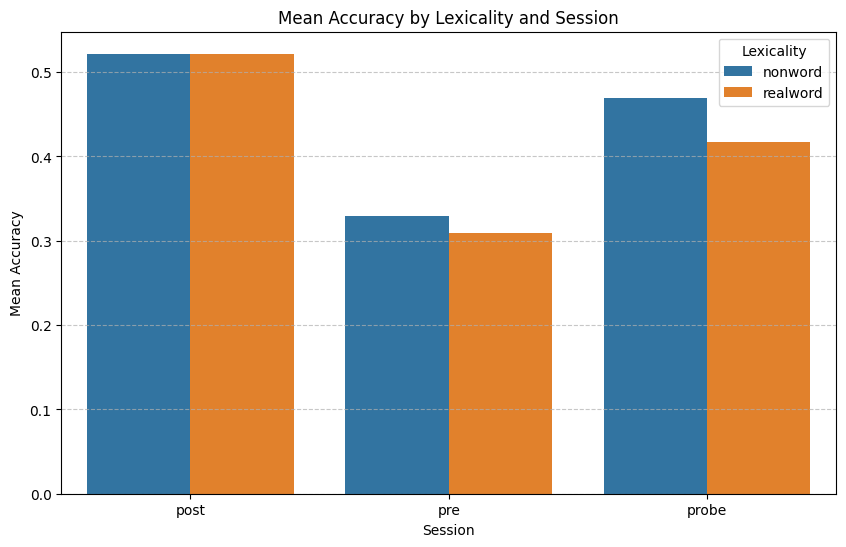

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

#calculating the mean accuracy grouped by lexicality and session
summary_accuracy = (
    df_item.groupby(["lexicality", "session"])
    ["accuracy"].mean().reset_index()
)

#creating a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='session', y='accuracy', hue='lexicality', data=summary_accuracy)

#adding title and labels
plt.title('Mean Accuracy by Lexicality and Session')
plt.xlabel('Session')
plt.ylabel('Mean Accuracy')
plt.legend(title='Lexicality')
plt.grid(axis='y', linestyle='--', alpha=0.7)

#displaying the plot
plt.show()
